# Sales Forecasting using DeepAR

1. [Introduction](#Introduction)
2. [Prepare Train and Test Datasets](#Prepare-Train-and-Test-Datasets)
3. [Model Training](#Model-Training)
   1. [Define-Hyperparameters](#Define-Hyperparameters)
   2. [Model Fitting](#Model-Fitting)
4. [Deploy Trained Model](#Deploy-Trained-Model)
5. [Consume Deployed Model](#Consume-Deployed-Model)

## Introduction
The [kaggle](https://www.kaggle.com/manjeetsingh/retaildataset) dataset contains historical sales for 45 stores, with each store belonging to a specific type (location and performance) and size. The retailer runs several promotional markdowns throughout the year. These markdowns precede holidays, such as SuperBowl, Labor Day, Thanksgiving, and Christmas.

We will forecast category sales for store 20. Remember that in the previous notebook where we explored sales data, we saved sales of store 20 in a csv file

In [2]:
import os
import shutil
import sagemaker.amazon.common as smac    
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
!pip install setuptools==65.5.0

In [4]:
# Print current working directory
print("Current Directory:", os.getcwd())

# List files in the current directory
print("Contents:", os.listdir(os.getcwd()))

Current Directory: /home/ec2-user/SageMaker/notebooks
Contents: ['Train_Sales_DeepAR.ipynb', 'retailsales.csv', 'EDA_RetailSales.ipynb', '.ipynb_checkpoints']


In [5]:
#Navidate to deep-ar directory to install the deepar package containing commonly used functions
path = ".."  # Navigate up one level to access setup.py
os.chdir(path)

# Verify the directory contains setup.py
print("After Navigation Current Directory:", os.getcwd())
print("Contents of Project Root Directory:", os.listdir())

#install predefined functions
!pip install .

After Navigation Current Directory: /home/ec2-user/SageMaker
Contents of Project Root Directory: ['notebooks', 'data', 'lost+found', '.virtual_documents', 'README.md', '.sparkmagic', 'build', 'deepar_sales_training.json', 'setup.py', 'deepar', 'deepar_sales_test.json', 'deepar.egg-info', '.ipynb_checkpoints']
Processing /home/ec2-user/SageMaker
  Preparing metadata (setup.py) ... done
  Created wheel for deepar: filename=deepar-0.0.0-py3-none-any.whl size=3441 sha256=352c19286d532296904d4dbf405bde9bf26406b9542b925b71f2d2b3406db652
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ujtnhvr/wheels/79/a2/86/f30415f29cd2ece5ccbccf03b1ed8d9cb848afeabedfec49df
Successfully built deepar
  Attempting uninstall: deepar
    Found existing installation: deepar 0.0.0
    Uninstalling deepar-0.0.0:
      Successfully uninstalled deepar-0.0.0


In [7]:
#Navigate to the parent directory to train the DeepAR model
# org_path = ".."
# os.chdir(org_path)

!pwd

/home/ec2-user/SageMaker


In [8]:
import deepar as da

## Prepare Train and Test Datasets
The datasets should be in JSON Lines format

In [9]:
train_key      = 'deepar_sales_training.json'
test_key       = 'deepar_sales_test.json'
#Prediction and context length for training the DeepAR model
prediction_length = 9
salesfn = 'data/store20_sales.csv'

salesdf = da.retailsales.prepareSalesData(salesfn)
testSet = da.retailsales.getTestSales(salesdf, test_key)
trainingSet = da.retailsales.getTrainSales(salesdf, train_key, prediction_length)

Note: We have only looked at store 20 sales. However, you can train on all store sales by including store number in the category list - for each series in train and test sets, include "cat": [department number, store number]

### Upload Input data to S3

In [18]:
import sagemaker
from sagemaker.estimator import Estimator
import boto3

bucket         = 'pe09'
prefix         = 'deepar-weekly-sales'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

# Update the session to match the S3 bucket region
sagemaker_session = sagemaker.Session(boto_session=boto3.Session(region_name="us-east-2"))

train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## Model Training

### Configuring the training job

In [23]:
from sagemaker.image_uris import retrieve

role = get_execution_role()
output_path = r's3://{0}/{1}'.format(bucket, output_prefix) 

# container = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
# Retrieve the container URI for DeepAR in the us-east-2 region
container = retrieve("forecasting-deepar", region="us-east-2")

deepAR = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=1,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sagemaker_session)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Define Hyperparameters

In [24]:
hyperparameters = {
    "time_freq": 'W', # weekly series
    "context_length": prediction_length, # how many data points are we going to look at before predicting
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40", # of cells to use in each of the hidden layers
    "num_layers": "2", # of hidden layers
    "likelihood": "gaussian",
    "epochs": "300", # max number of passses over the training data
    "mini_batch_size": "32", # size of the mini batches used during training
    "learning_rate": "0.00001",
    "dropout_rate": "0.05", #for each iteration, a random subset of hidden neurons are not updated
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

deepAR.set_hyperparameters(**hyperparameters) #** = arbitrary number of arguments to functions

### Model Fitting

In [25]:
data_channels = {"train": train_path, "test": test_path}
deepAR.fit(inputs=data_channels, wait=True, logs=True)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2024-12-07-01-37-36-780


2024-12-07 01:37:39 Starting - Starting the training job...
2024-12-07 01:37:54 Starting - Preparing the instances for training...
2024-12-07 01:38:40 Downloading - Downloading the training image..............Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/07/2024 01:40:55 INFO 140215349077824] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat':

## Deploy Trained Model

In [26]:
deepAR_predictor = deepAR.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: forecasting-deepar-2024-12-07-01-42-35-490
INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-2024-12-07-01-42-35-490
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2024-12-07-01-42-35-490


-------!

## Consume Deployed Model

Predicted Sales:  [65935.3671875, 78077.0703125, 63357.61328125, 62673.828125, 74889.03125, 83905.4375, 90564.859375, 75975.2578125, 91030.078125]
Actual Sales:  [100422.86, 94987.08, 90889.75, 115695.71, 100372.02, 96616.19, 93460.57, 99398.64, 105059.88]


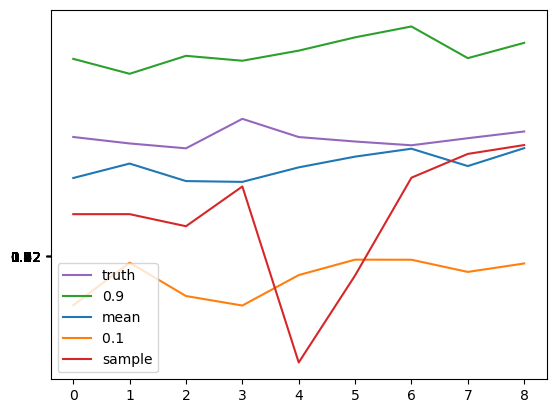

In [27]:
#Predict last 9 weeks of a department and compare to ground truth

deepAR_predictor.content_type = 'application/json'
dept = 90 

prediction_data = da.salesinference.buildInferenceData(dept, trainingSet, testSet)
#print(prediction_data)

result = deepAR_predictor.predict(prediction_data)

y_mean, y_q1, y_q2, y_sample = da.salesinference.getInferenceSeries(result)
print("Predicted Sales: ", y_mean)
print("Actual Sales: ", list(testSet[dept]['Weekly_Sales'][134:]))

da.salesinference.plotResults(prediction_length, result, truth=True, truth_data=testSet[dept]['Weekly_Sales'][134:], truth_label='truth')